<h2><b>Importing libraries</b></h2>

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, f1_score, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import time
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<h2><b>Getting data</b></h2>

In [2]:
histVale = web.DataReader('VALE', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histAzul = web.DataReader('AZUL4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histPetro = web.DataReader('PBR', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histItau = web.DataReader('ITUB', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [3]:
historicStock = [histVale, histAzul, histBB, histPetro, histItau]

In [4]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [5]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [6]:
calculate_daily_inflation(monthlyInflation2018)

In [7]:
historicStock[4]

,High,Low,Open,Close,Volume,Adj Close,Month,DailyInflation,InflationHigh,InflationLow,InflationOpen,InflationClose
Date,,,,,,,,,,,,
2018-01-02,9.020000,8.846667,8.873333,9.020000,9065100.0,7.417422,1,1.000270,9.02,8.84,8.87,9.02
2018-01-03,9.153333,8.980000,9.006667,9.140000,26839200.0,7.516098,1,1.000541,9.15,8.98,9.00,9.14
2018-01-04,9.353333,9.226667,9.260000,9.253333,29857200.0,7.609297,1,1.000812,9.35,9.22,9.25,9.25
2018-01-05,9.380000,9.186667,9.220000,9.366667,10938600.0,7.702496,1,1.001082,9.37,9.18,9.21,9.36
2018-01-08,9.360000,9.233333,9.306667,9.240000,16406850.0,7.598333,1,1.001353,9.35,9.22,9.29,9.23
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,9.020000,8.730000,8.970000,8.760000,16073200.0,7.679347,12,1.073060,8.41,8.14,8.36,8.16
2018-12-24,8.790000,8.600000,8.690000,8.630000,6001200.0,7.565382,12,1.073449,8.19,8.01,8.10,8.04
2018-12-26,8.640000,8.430000,8.590000,8.640000,27750300.0,7.574151,12,1.073837,8.05,7.85,8.00,8.05


<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [8]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [9]:
calculate_lines()

In [10]:
def calculate_bollinger_bands():
    for stock in historicStock:
        stock["30_MA"] = stock["Close"].rolling(window=30).mean()
        stock["30_STD"] = stock["Close"].rolling(window=30).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
        
        plt.plot(stock["LowerBollinger"], label="Lower")
        plt.plot(stock["UpperBollinger"], label="Upper")
        plt.plot(stock["Close"], label="Close")
        plt.legend()
        plt.show()

In [11]:
def calculate_bollinger_bands_stock(stock):
    stock["30_MA"] = stock["Close"].rolling(window=30).mean()
    stock["30_STD"] = stock["Close"].rolling(window=30).std()
    stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
    stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
    stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
    stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]

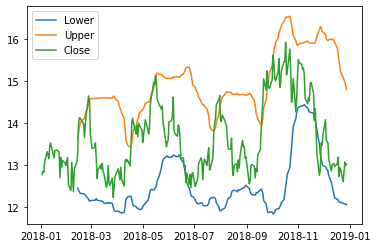

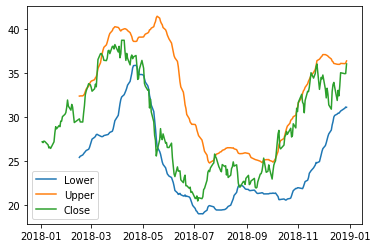

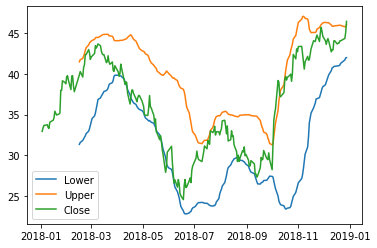

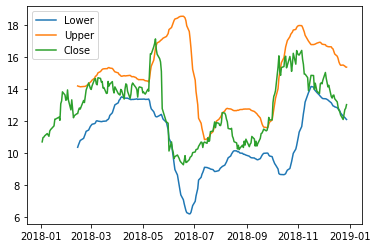

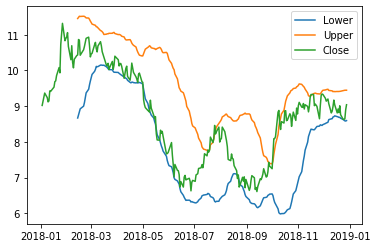

In [12]:
calculate_bollinger_bands()

In [13]:
def upOrDown():
    for stock in historicStock:
        stock["UpDown"] = stock["Close"].diff();
        stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [14]:
def upOrDownNpArray(array):
    difference = np.diff(array)
    diffReturn = []
    for i in difference:
        if i >= 0:
            diffReturn.append(1)
        else:
            diffReturn.append(0)
    return np.array(diffReturn)

In [15]:
def upOrDownStock(stock):
    stock["UpDown"] = stock["Close"].diff();
    stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [16]:
upOrDown()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [17]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [18]:
def calculate_RSI_stock(window, stock, inflation=False):
    if inflation == False:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
    else:
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [19]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [20]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.legend()
    plt.show()

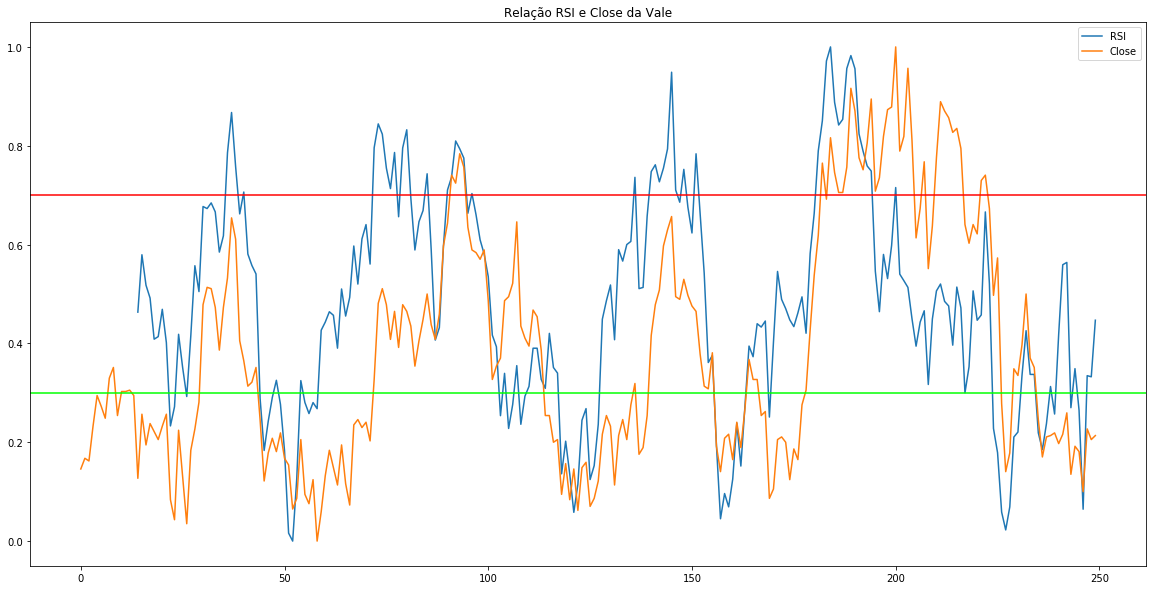

In [21]:
plot_rsi_close(historicStock[0], 'Vale')

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [22]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [23]:
def calculate_MFI_stock(window, stock, inflation=False):
    if inflation == False:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))
    else:
        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [24]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [25]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [26]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [27]:
def calculate_stochastic_oscillator_stock(window, stock, inflation=False):
    if inflation == False:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
    else:  
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [28]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [29]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Function to plot correlation matrix</b></h2>

In [30]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]].corr()

    sns.heatmap(corrMatrix, annot=True)
    plt.figure(figsize = (100,100))
    plt.show()

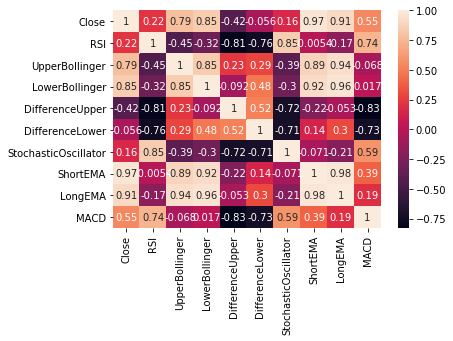

<Figure size 7200x7200 with 0 Axes>

In [31]:
show_corr_matrix(historicStock[4])

<h2><b>Function to predict traditional SVM</b></h2>

In [32]:
svmRegressorClose = svm.SVR(kernel="linear")
svmRegressorHigh = svm.SVR(kernel="linear")
svmRegressorLow = svm.SVR(kernel="linear")
svmRegressorNu = svm.NuSVR(kernel="linear")

In [79]:
def predict_svm_traditional(stock, inflation=False, feature='close'):
    if feature == 'close':
        if inflation == False:
            stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
            stockY = stock["InflationClose"][15:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        svmRegressorClose.fit(X_train, y_train)
        print(svmRegressorClose)

        print(X_test)

        y_pred = svmRegressorClose.predict(X_test)
        print('Predicted values: ', y_pred)
        print('Testing values: ', y_test)
#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train
#     elif feature == 'high':
#         if inflation == False:
#             stockX = stock[["RSI", "ShortEMA", "MACD"]][15:]
#             stockY = stock["High"][15:]
#         else:
#             stockX = stock[["InflationRSI", "InflationShortEMA", "InflationMACD"]][15:]
#             stockY = stock["InflationHigh"][15:]
#         X = np.array(stockX)
#         y = np.array(stockY)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

#         svmRegressorHigh.fit(X_train, y_train)

#         print(X_test)

#         y_pred = svmRegressorHigh.predict(X_test)
#         print('Predicted values: ', y_pred)
#         print('Testing values: ', y_test)
#         print('Coefficients: \n', svmRegressorHigh.coef_)

#         return y_pred, y_test, y_train
#     elif feature == 'low':
#         if inflation == False:
#             stockX = stock[["RSI","ShortEMA", "MACD"]][15:]
#             stockY = stock["Low"][15:]
#         else:
#             stockX = stock[["InflationRSI", "InflationShortEMA", "InflationMACD"]][15:]
#             stockY = stock["InflationLow"][15:]
#         X = np.array(stockX)
#         y = np.array(stockY)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

#         svmRegressorLow.fit(X_train, y_train)

#         print(X_test)

#         y_pred = svmRegressorLow.predict(X_test)
#         print('Predicted values: ', y_pred)
#         print('Testing values: ', y_test[1:])
#         print('Coefficients: \n', svmRegressorLow.coef_)

#         return y_pred, y_test[1:], y_train
        

In [103]:
def predict_plot_svm(stock, inflation=False, feature='close'):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    print("PREDIC: ", y_pred)
    
    print("PRED: ", y_pred)
    print("TEST: ",y_test)
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    comparison = (predictUpDown == realUpDown)
    comparison = comparison.sum()
    
    print("Razão: ", comparison/len(predictUpDown))
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(range(len(y_pred)), y_pred, marker="x", label="Prediction")
    plt.legend()
    plt.show()

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[[ 8.09333324e+00  8.02394776e+01  7.79289884e+00  6.30399008e+00
  -3.00434405e-01 -1.78934316e+00  8.40163782e+01  7.46272254e+00
   1.77664868e-01]
 [ 8.14666653e+00  7.86407286e+01  7.93083394e+00  6.26027721e+00
  -2.15832584e-01 -1.88638932e+00  8.66379126e+01  7.56794469e+00
   2.19064141e-01]
 [ 8.83333302e+00  8.48038930e+01  8.20387607e+00  6.12367949e+00
  -6.29456946e-01 -2.70965352e+00  9.12912773e+01  7.76261982e+00
   3.03779826e-01]
 [ 8.88000011e+00  8.46913294e+01  8.43805118e+00  6.01439325e+00
  -4.41948939e-01 -2.86560686e+00  9.33933991e+01  7.93452448e+00
   3.70413366e-01]
 [ 8.49333286e+00  7.33333090e+01  8.56915357e+00  5.98951304e+00
   7.58207070e-02 -2.50381982e+00  7.59759537e+01  8.02049500e+00
   3.87552646e-01]
 [ 8.34666729e+00  6.83741624e+01  8.66646249e+00  5.98064861e+00
   3.19795201e-01 -2.366018

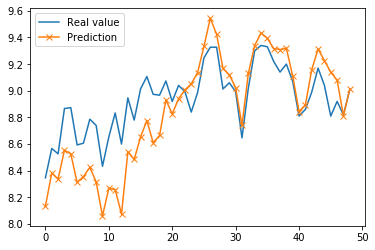

In [104]:
predict_plot_svm(historicStock[4])

In [36]:
# def predict_svm_traditional_forward_correct(stock, n, inflation=False):
#     y_pred = []
#     stock = stock[["Close", "High", "Low", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD"]][30:]
    
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]]
#         stockXHiLo = stock[["RSI", "ShortEMA", "MACD"]]
#         stockY = stock["Close"]
#         stockYHi = stock["High"]
#         stockYLo = stock["Low"]
#     else:
#         stockX = stock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD", "InflationHigh", "InflationLow"]]
#         stockY = stock["InflationClose"]
#     X = np.array(stockX)
#     y = np.array(stockY)
    
#     df_train, df_test = train_test_split(stock, random_state=42, shuffle=False)
#     print(len(df_train.index))
#     print(len(df_test.index))
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
#     print(len(X_train))
#     print(len(X_test))
#     X_test = np.append(X_train[-30:], [X_test[0]], axis=0)
#     y_pred = [y_train[-1]]
    
    
#     df_final = df_train[-30:]
    

#     svmRegressorClose.fit(X_train, y_train)
    
    
#     X = np.array(stockXHiLo)
#     y = np.array(stockYHi)
#     X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X, y, random_state=42, shuffle=False)
#     svmRegressorHigh.fit(X_train_high, y_train_high)
    
    
#     X = np.array(stockXHiLo)
#     y = np.array(stockYLo)
#     X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X, y, random_state=42, shuffle=False)
#     svmRegressorLow.fit(X_train_low, y_train_low)
    
    
    
#     i = 0
    
#     while i < n:
        
#                                                             ##RSI ESTA DANDO MUITO ALTO
#         shortEma = df_final["Close"][-12:].mean()
#         longEma = df_final["Close"][-26:].mean()
#         macd = shortEma - longEma
                 
        
#         df_final = df_final.append({"Close": y_pred[-1], "High": 0, "Low": 0,"RSI": 0, "UpperBollinger": 0, "LowerBollinger": 0, "DifferenceUpper": 0, "DifferenceLower": 0, "StochasticOscillator": 0, "ShortEMA": shortEma, "LongEMA": longEma, "MACD": macd}, ignore_index=True)
#         calculate_RSI_stock(14, df_final)
#         high_pred = svmRegressorHigh.predict(np.array(df_final[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         low_pred = svmRegressorLow.predict(np.array(df_final[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         df_final["High"].iloc[-1] = high_pred if y_pred[-1] < high_pred else y_pred[-1]
#         df_final["Low"].iloc[-1] = low_pred if y_pred[-1] > low_pred else y_pred[-1]
        
#         pred = svmRegressorClose.predict((X_test[-1]).reshape(1, -1))
#         df_final["Close"].iloc[-1] = pred[0]
#         y_pred = np.append(y_pred, pred[0])
        
#         calculate_bollinger_bands_stock(df_final)
#         calculate_stochastic_oscillator_stock(14, df_final)
        
        
#         X_test = np.append(X_test, [(df_final[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]].iloc[-1]).to_numpy()], axis=0)
        
#         i += 1
        
# #     print('R^2 value: ', r2_score(y_test, y_pred))
# #     print('MAE score: ', mean_absolute_error(y_test, y_pred))
# #     print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        
#     plt.plot(y_test[:n], label="Real value")
#     plt.plot(y_pred, label="Prediction")
#     plt.legend()
#     plt.show()

In [37]:
# predict_svm_traditional_forward_correct(historicStock[3], 14)

In [38]:
# def predict_svm_traditional_forward(stock, n, inflation=False):
#     y_test = []
#     y_pred = []
#     provStock = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "High", "Low", "Close"]][:30]
#     y_test = np.array(stock["Close"][30:(30+n)])
#     if inflation == False:
#         stockX = provStock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]]
#         stockY = provStock["Close"]
#     else:
#         stockX = provStock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD", "InflationHigh", "InflationLow"]]
#         stockY = provStock["InflationClose"]
#     X = np.array(stockX)
#     y = np.array(stockY)
    
#     i = 0
#     while i < n:
#         y[-1] = svmRegressorClose.predict((X[-1]).reshape(1, -1))
#         provStock["Close"].iloc[-1] = y[-1]
#         y_pred.append(y[-1])

#         shortEma = y[-12:].mean()
#         longEma = y[-26:].mean()
#         macd = shortEma - longEma
        
#         provStock = provStock.append({"RSI": 0, "UpperBollinger": 0, "LowerBollinger": 0, "DifferenceUpper": 0, "DifferenceLower": 0, "StochasticOscillator": 0, "ShortEMA": shortEma, "LongEMA": longEma, "MACD": macd, "High": 0, "Low": 0, "Close": y[-1]}, ignore_index=True)
#         calculate_RSI_stock(14, provStock)
#         high_pred = svmRegressorHigh.predict(np.array(provStock[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         low_pred = svmRegressorLow.predict(np.array(provStock[["RSI", "ShortEMA", "MACD"]])[-1].reshape(1, -1))
#         provStock["High"].iloc[-1] = high_pred
#         provStock["Low"].iloc[-1] = low_pred
        
#         calculate_bollinger_bands_stock(provStock)
#         calculate_stochastic_oscillator_stock(14, provStock)
#         X = np.array(provStock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]])
#         print(X)
#         y = np.append(y, [0])
#         i += 1
        
# #     print('R^2 value: ', r2_score(y_test, y_pred))
# #     print('MAE score: ', mean_absolute_error(y_test, y_pred))
# #     print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))

#     plt.plot(y_test, label="Real value")
#     plt.plot(y_pred, label="Prediction")
#     plt.legend()
#     plt.show()

# #     svmRegressor.fit(X_train, y_train)
    
# #     print(X_test)
    
# #     y_pred = svmRegressor.predict(X_test)
# #     print('Predicted values: ', y_pred)
# #     print('Testing values: ', y_test)
# #     print('Coefficients: \n', svmRegressor.coef_)
    
# #     return y_pred, y_test, y_train

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[[ 1.06400003e+01  3.06049862e+01  1.26559886e+01  1.01380115e+01
   2.01598822e+00 -5.01988850e-01  7.91668703e+00  1.13037023e+01
  -5.15316076e-02]
 [ 1.02600002e+01  2.70440199e+01  1.26832148e+01  1.00834520e+01
   2.42321452e+00 -1.76548249e-01  1.14506401e+00  1.11431328e+01
  -1.30972738e-01]
 [ 1.04899998e+01  2.77258456e+01  1.26734560e+01  1.01025440e+01
   2.18345622e+00 -3.87455736e-01  1.12781993e+01  1.10426508e+01
  -1.73372831e-01]
 [ 1.02200003e+01  9.75609189e+00  1.27011878e+01  1.00474789e+01
   2.48118754e+00 -1.72521376e-01  1.18112941e+00  1.09160892e+01
  -2.26154941e-01]
 [ 1.03100004e+01  1.26279852e+01  1.27223772e+01  1.00009563e+01
   2.41237673e+00 -3.09044148e-01  5.83659883e+00  1.08228447e+01
  -2.57751682e-01]
 [ 1.05000000e+01  1.86666548e+01  1.27276553e+01  9.98834486e+00
   2.22765525e+00 -5.116551

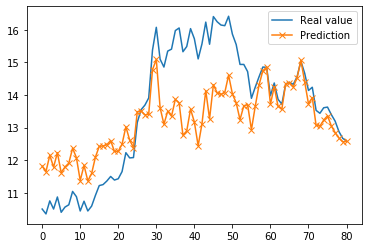

In [69]:
predict_plot_svm(historicStock[3])

In [40]:
# predict_svm_traditional_forward(historicStock[4], 14) 

<h2><b>Function to predict Nu SVM</b></h2>

In [92]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD"]][15:]
        stockY = stock["Close"][15:]
    else:
        stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    svmRegressorNu.fit(X_train, y_train)
    
    y_pred = svmRegressorNu.predict(X_test)
    print('Predicted values: ', y_pred)
    print('Testing values: ', y_test)
    print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [93]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    print("PREDIC: ", y_pred)
    
    print("PRED: ", y_pred)
    print("TEST: ",y_test)
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    comparison = (predictUpDown == realUpDown)
    comparison = comparison.sum()
    
    print("Razão: ", comparison/len(predictUpDown))
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(range(len(y_pred)), y_pred, marker="x", label="Prediction")
    plt.legend()
    plt.show()

Predicted values:  [7.43362682 7.51938416 7.66559671 8.04010986 7.96361791 8.06528658
 8.33295346 8.50145621 8.42105411 8.34393051 8.53104593 8.63288947
 8.75271378 8.8157457  8.82165806 8.83181681 8.85523115 8.66646363
 8.65226815 8.70648421 8.64154088 8.38949578 8.73659796 8.70070576
 8.7956375  8.88363601 8.76142638 8.66879297 8.85086785 8.82391757
 8.7706211  8.84967928 8.83999456 8.86121875 8.92609918 9.15746613
 9.1115828  9.08914697 9.0540845  8.93707879 8.83188734 9.07682049
 9.14842424 9.34103682 9.4276656  9.32172764 9.34930116 9.19831112
 9.12149431 8.88554263 8.72159387 8.93233771 8.94478819 8.9083483
 8.86316199 8.82263547 8.60006112 8.73266143]
Testing values:  [8.14666653 8.83333302 8.88000011 8.49333286 8.34666729 8.5666666
 8.52666664 8.86666679 8.87333298 8.59333324 8.60666656 8.78666687
 8.73999977 8.4333334  8.65333271 8.83333302 8.60000038 8.94666672
 8.77999973 9.01333332 9.10666656 8.97333336 8.96666718 9.07333279
 8.92000008 9.03999996 8.99333286 8.84000015 8.98

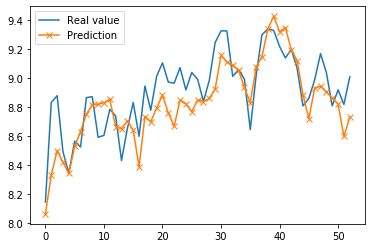

In [95]:
predict_plot_svm_nu(historicStock[4])

<h2><b>Scaling data for LSTM</b></h2>

In [44]:
# scaler = MinMaxScaler()
# stockScaled = []
# stocksScaled = []

# for stock in historicStock:
#     stocksScaled.append(stock)
    
# for stock in stocksScaled:
#     stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [45]:
# def predict_LSTM(stock, inflation=False):
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
#         stockY = stock["Close"][30:]
#     else:
#         stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
#         stockY = stock["InflationClose"][15:]
#     X = np.array(stockX)
#     y = np.array(stockY)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
#     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#     y_train = y_train.reshape(y_train.shape[0], 1, 1)
#     y_test = y_test.reshape(y_test.shape[0], 1, 1)
    
#     model = Sequential()

#     model.add(LSTM(128, activation='sigmoid', input_shape=(8,1)))
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(128, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(32, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(10, activation='softmax'))
#     model.add(Dropout(0.2))
    
#     model.compile(optimizer=Adam(lr=1e-3, decay=1e-5), metrics=['accuracy'])
    
#     model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [46]:
# predict_LSTM(stockScaled[0])

In [47]:
clf = KernelRidge(alpha=1.0)

In [122]:
def predict_kernel_ridge(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationRSI", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    clf = KernelRidge(alpha=1.0)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    comparison = (predictUpDown == realUpDown)
    comparison = comparison.sum()
    
    print("Razão: ", comparison/len(predictUpDown))
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('F1 score: ', f1_score(predictUpDown, realUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(range(len(y_pred)), y_pred, marker="x", label="Prediction")
    plt.legend()
    plt.show()

[0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1
 1 0 0 1 0 1 1 0 0 1]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1]
Razão:  0.8723404255319149
R^2 value:  0.803174500429519
F1 score:  0.896551724137931
MAE score:  0.7628745850201994
RMSE value:  0.9773184968000089


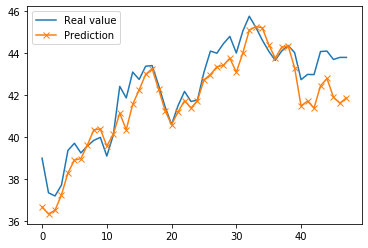

In [130]:
predict_kernel_ridge(historicStock[2])